In [2]:
print()

In [3]:
import sys
print(sys.prefix)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/home/jinda/anaconda3/envs/cs224n
Thu Dec  7 20:48:05 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:06:00.0 Off |                  N/A |
| 33%   45C    P8              17W / 250W |     21MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------------------------------

In [4]:
# we use data from https://huggingface.co/datasets/cnn_dailymail

In [5]:
!pip install datasets evaluate rouge_score


1. Data downloading

In [6]:
# If we download data using hugging face dataset
from datasets import load_dataset
# I just downloaded the smallest subset
docs = load_dataset('cnn_dailymail', '1.0.0', split='test')

In [7]:
# Get a train set and a val set from the downloaded data
docs_train_test = docs.train_test_split(train_size=0.2, test_size=0.05)
docs_train_test

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 2298
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 575
    })
})

In [8]:
# Splitting the training data into train and validation sets
docs_train_val = docs_train_test['train'].train_test_split(train_size=0.8, test_size=0.2)

train_set = docs_train_val['train']
validation_set = docs_train_val['test']
test_set = docs_train_test['test']
print(train_set)
print(validation_set)
print(test_set)

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 1838
})
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 460
})
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 575
})


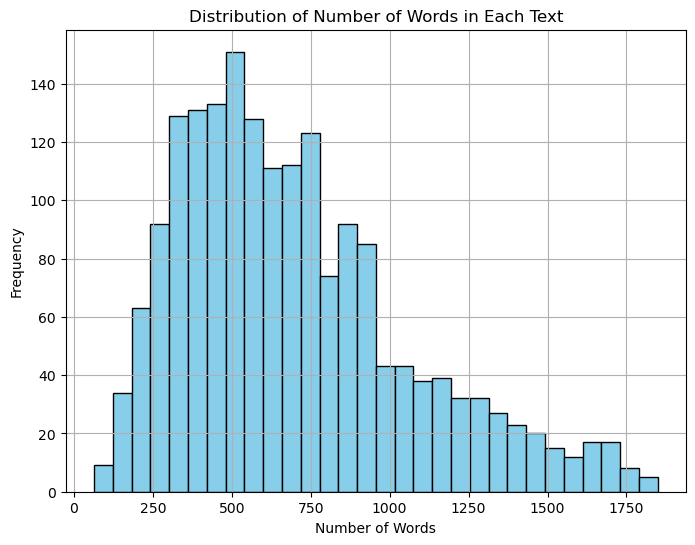

In [51]:
import matplotlib.pyplot as plt

# Assuming train_set is a Dataset object with 'article' column containing text data

# Calculate the number of words in each article
num_words = [len(article.split()) for article in train_set['article']]

# Create a histogram to visualize the distribution of word counts
plt.figure(figsize=(8, 6))
plt.hist(num_words, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Words in training')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
from datasets import DatasetDict

# Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_set,
    'validation': validation_set,
    'test': test_set
})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 1838
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 460
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 575
    })
})


In [10]:
from rouge_score import rouge_scorer

def rouge_evaluation(predicted_summaries, ground_truth_summaries):
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {}
    for idx, pred_summary in enumerate(predicted_summaries):
        scores = rouge.score(pred_summary, ground_truth_summaries[idx])
        for metric, score in scores.items():
            if metric not in rouge_scores:
                rouge_scores[metric] = []
            rouge_scores[metric].append(score.fmeasure)
    return rouge_scores

import matplotlib.pyplot as plt

# Function to plot ROUGE scores
def plot_rouge_scores(rouge_scores):
    metrics = list(rouge_scores.keys())
    scores = list(rouge_scores.values())
    plt.figure(figsize=(10, 6))
    for i in range(len(metrics)):
        plt.plot(scores[i], label=metrics[i])
    plt.xlabel('Document Index')
    plt.ylabel('ROUGE Score')
    plt.legend()
    plt.title('ROUGE Scores for TF-IDF Summarization')
    plt.show()

# Random

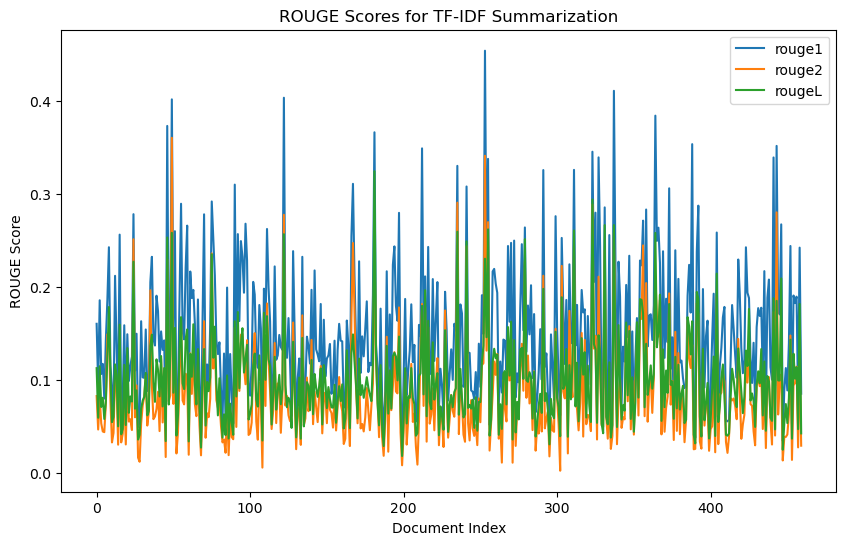

In [11]:
import random

# Random Summarization (Baseline)
def random_summarization(documents, top_n=128):
    summaries = []
    for doc in documents:
        sentences = doc.split('.')  # Split document into sentences
        selected_sentences = random.sample(sentences, min(top_n, len(sentences)))
        summary = ' '.join(selected_sentences)
        summaries.append(summary)
    return summaries

# Random summarization for the validation set
random_summaries = random_summarization(validation_set['article'])

# ROUGE evaluation for Random summaries
rouge_scores_random = rouge_evaluation(random_summaries, validation_set['highlights'])

# Plotting the ROUGE scores obtained from Random summarization
plot_rouge_scores(rouge_scores_random)

In [12]:
import numpy as np
print(np.mean(rouge_scores_random['rouge1']))
print(np.mean(rouge_scores_random['rouge2']))
print(np.mean(rouge_scores_random['rougeL']))

0.15233097840342566
0.08714867267939329
0.09904265465157991


# tfidf

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# 1. TF-IDF Computation
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(train_set['article'])

# 2. Summarization using TF-IDF
def tfidf_summarization(documents, top_n=128):
    summaries = []
    for doc in documents:
        doc_tfidf = tfidf_vectorizer.transform([doc])
        similarity_matrix = cosine_similarity(doc_tfidf, tfidf_matrix)
        scores = normalize(similarity_matrix, norm='l1').flatten()
        top_idx = scores.argsort()[-top_n:][::-1]
        summary = ' '.join([sent for i, sent in enumerate(doc.split()) if i in top_idx])
        summaries.append(summary)
    return summaries

tfidf_summaries = tfidf_summarization(validation_set['article'])

In [14]:

rouge_scores_tfidf = rouge_evaluation(tfidf_summaries, validation_set['highlights'])

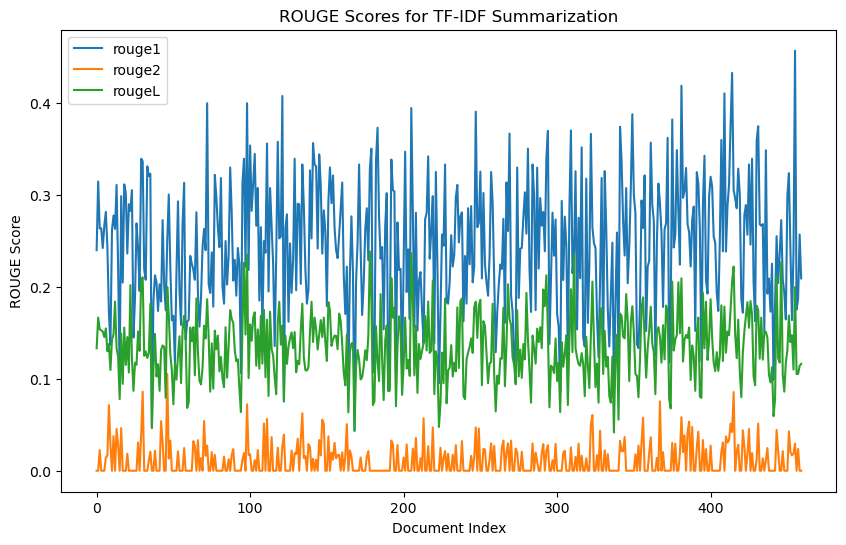

In [15]:


# Plotting the ROUGE scores obtained from TF-IDF summarization
plot_rouge_scores(rouge_scores_tfidf)

In [16]:
import numpy as np
print(np.mean(rouge_scores_tfidf['rouge1']))
print(np.mean(rouge_scores_tfidf['rouge2']))
print(np.mean(rouge_scores_tfidf['rougeL']))

0.24642547977602952
0.012153927629167987
0.1345143611401233


# Textrank

In [17]:
!pip install summa

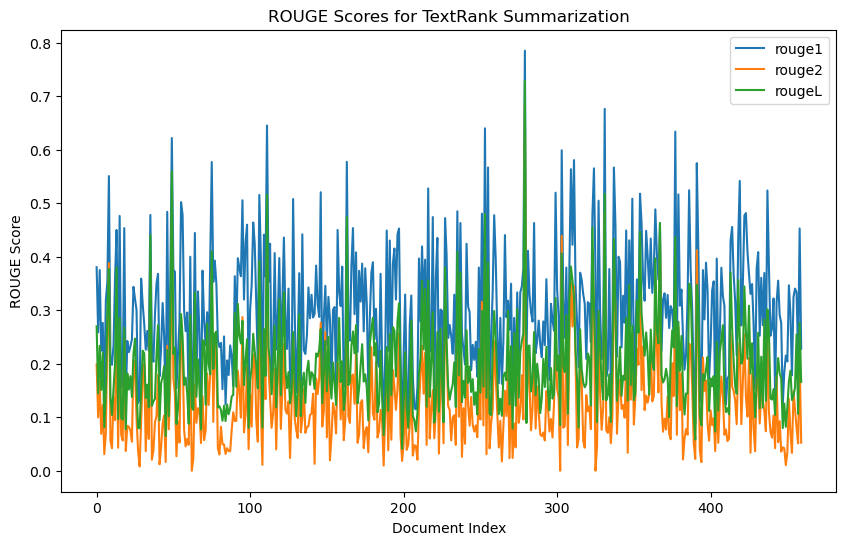

In [18]:
from summa import summarizer
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

# Function for TextRank summarization
def textrank_summarization(documents, top_n=128):
    summaries = []
    for doc in documents:
        summary = summarizer.summarize(doc, ratio=0.2)  # You can adjust the ratio as needed
        summaries.append(summary)
    return summaries

# TextRank summarization for the validation set
textrank_summaries = textrank_summarization(validation_set['article'])

# ROUGE evaluation for TextRank summaries
rouge_scores_textrank = rouge_evaluation(textrank_summaries, validation_set['highlights'])

# Function to plot ROUGE scores
def plot_rouge_scores(rouge_scores):
    metrics = list(rouge_scores.keys())
    scores = list(rouge_scores.values())
    plt.figure(figsize=(10, 6))
    for i in range(len(metrics)):
        plt.plot(scores[i], label=metrics[i])
    plt.xlabel('Document Index')
    plt.ylabel('ROUGE Score')
    plt.legend()
    plt.title('ROUGE Scores for TextRank Summarization')
    plt.show()

# Plotting the ROUGE scores obtained from TextRank summarization
plot_rouge_scores(rouge_scores_textrank)

In [19]:
import numpy as np
print(np.mean(rouge_scores_textrank['rouge1']))
print(np.mean(rouge_scores_textrank['rouge2']))
print(np.mean(rouge_scores_textrank['rougeL']))

0.30789236508197204
0.1304875092612819
0.19866061691337042


# pegasus

In [20]:
!pip install sentencepiece

In [21]:
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration
# !pip install sentencepiece
import tensorflow as tf
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')

2023-12-07 20:48:41.373121: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 20:48:41.416715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 20:48:41.417640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 20:48:43.184386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [22]:
prefix = 'summarize:'

def tokenization(docs, max_article_length=512, max_summary_length=128):
    inputs = tokenizer(docs['article'], max_length=max_article_length, truncation=True, padding='max_length')
    targets = tokenizer(docs['highlights'], max_length=max_summary_length, truncation=True, padding='max_length')

    inputs["labels"] = targets["input_ids"]
    return inputs

# tokenize the data
tokenized_docs = dataset_dict.map(tokenization, batched=True)
tokens_docs = tokenized_docs.remove_columns(['article','highlights', 'id'])
tokens_docs

Map:   0%|          | 0/1838 [00:00<?, ? examples/s]

Map:   0%|          | 0/460 [00:00<?, ? examples/s]

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1838
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 460
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 575
    })
})

In [23]:
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration
# Load the Pegasus model
model = TFPegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')

2023-12-07 20:48:56.767958: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import DataCollatorForSeq2Seq
# get a collator for data padding
collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [25]:
import numpy as np
import evaluate

rouge = evaluate.load("rouge")

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

#     prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
#     result["gen_len"] = np.mean(prediction_lens)

#     return {k: round(v, 4) for k, v in result.items()}

# process data
tf_train_set = model.prepare_tf_dataset(
    tokens_docs['train'],
    shuffle=True,
    batch_size=16,
    tokenizer= tokenizer,
    collate_fn=collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokens_docs['test'],
    shuffle=False,
    batch_size=8,
    tokenizer= tokenizer,
    collate_fn=collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokens_docs['validation'],
    shuffle=False,
    batch_size=8,
    tokenizer= tokenizer,
    collate_fn=collator,
)

/home/jinda/anaconda3/envs/cs224n/lib/python3.11/site-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [26]:
from transformers import create_optimizer, AdamWeightDecay
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [22]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [23]:
callbacks = [metric_callback]
# Training
history=model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=3)

Epoch 1/3


2023-11-29 14:57:36.166285: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6298206208 exceeds 10% of free system memory.


  1/114 [..............................] - ETA: 4:06:52 - loss: 3.5897

2023-11-29 14:59:02.011933: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6298206208 exceeds 10% of free system memory.


  2/114 [..............................] - ETA: 2:40:13 - loss: 3.8648

2023-11-29 15:00:27.040645: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6298206208 exceeds 10% of free system memory.


  3/114 [..............................] - ETA: 2:36:29 - loss: 3.6749

2023-11-29 15:01:49.626335: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6298206208 exceeds 10% of free system memory.


  4/114 [>.............................] - ETA: 2:32:22 - loss: 3.6549

2023-11-29 15:03:10.971400: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6298206208 exceeds 10% of free system memory.


114/114 [==============================] - 11300s 99s/step - loss: 2.8727 - val_loss: 2.1054
Epoch 2/3
114/114 [==============================] - 10421s 91s/step - loss: 2.4188 - val_loss: 1.9811
Epoch 3/3
114/114 [==============================] - 10074s 88s/step - loss: 2.2719 - val_loss: 1.9259


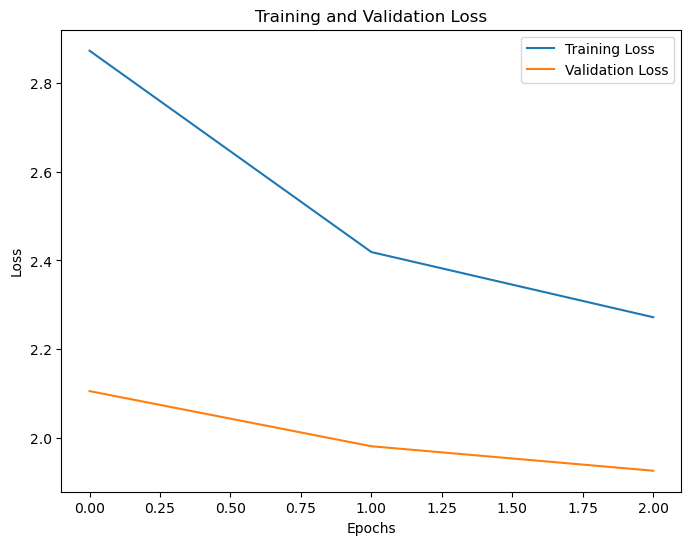

In [32]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# Define the path where you want to save the model
save_path = "./my_pegasus_model"

# Save the model
# model.save_pretrained(save_path)

In [28]:
# Load the saved model
loaded_model = TFPegasusForConditionalGeneration.from_pretrained(save_path)
loaded_model

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

All the layers of TFPegasusForConditionalGeneration were initialized from the model checkpoint at ./my_pegasus_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFPegasusForConditionalGeneration for predictions without further training.


In [29]:
from transformers import pipeline

pipe = pipeline("summarization", model=model, tokenizer=tokenizer, framework="tf")

In [36]:
eval_articles = docs['article'][-10:]
eval_highlights = docs['highlights'][-10:]

In [34]:
import evaluate
# get an evaluation metric
rouge_score = evaluate.load("rouge")

In [37]:
truncated_articles = [article[:512] for article in eval_articles]
generated_summaries = [pipe(article) for article in truncated_articles]

In [50]:
for i in range(-5, 0):
    print("Reference Summary:")
    print(eval_highlights[i])
    print("Generated Summary:")
    print(generated_summaries[i])
    print("=" * 20)

Reference Summary:
Operators are charging up to 20p a minute - even if 0800 numbers are free . Some are important services run by Government and NHS departments . Watchdog Ofcom published proposals to put an end to the rip-off in July .
Generated Summary:
[{'summary_text': 'Mobile phone users will no longer be able to call NHS call centres for free under plans being considered by the government.'}]
Reference Summary:
Bali Nine ringleaders will face the firing squad at midnight on Tuesday . Andrew Chan and Myruan Sukumaran have requested their last wishes . The men will likely be executed at a place called Nirbaya, aka 'Death Valley' White clothing will be given to them to wear which represents the after life . A cross will be placed over their heart as a target for the riflemen . They can choose to stand, sit or kneel before facing their demise . They are then given a maximum of three minutes to calm down . Three shooters will have live rounds and nine other will have blanks . If docto

In [44]:
generated_summaries

[[{'summary_text': 'A woman who was doused in petrol and set alight by her ex-boyfriend is appealing her sentence.'}],
 [{'summary_text': 'All images are copyrighted.'}],
 [{'summary_text': "The chancellor's Spending Review is due to be published on Wednesday."}],
 [{'summary_text': 'All images are copyrighted.'}],
 [{'summary_text': 'An HIV self-testing kit is on sale for the first time in the UK.'}],
 [{'summary_text': 'Mobile phone users will no longer be able to call NHS call centres for free under plans being considered by the government.'}],
 [{'summary_text': 'As Indonesia prepares to carry out the execution of three Australian drug smugglers, the BBC takes a look at their final moments.'}],
 [{'summary_text': 'Manchester City defender Vincent Kompany has been ruled out for up to three months with a knee injury.'}],
 [{'summary_text': "It's been a record-breaking year for Apple."}],
 [{'summary_text': "The brother of the former husband of Nicole Kidman has paid tribute to him as

In [46]:
# convert predictions and references to lists of strings
predictions = [str(p) for p in generated_summaries]
references = [str(r) for r in eval_highlights]

scores = rouge_score.compute(predictions=predictions, references=references)

In [47]:
scores

{'rouge1': 0.11770144140520863,
 'rouge2': 0.01801262878032569,
 'rougeL': 0.07538149143942391,
 'rougeLsum': 0.07436668726741713}